In [ ]:
!pip install awswrangler mlflow

The main tables available for this project is orders and order_items.
The order table indicate a purchase.
  - Which customer made the purchase?
  - Status of the purchase (invoiced, delivered, approved...)
  - Purchase timestamp.
  - Delivery Carrier timestamp.
  - Delivery to customer timestamp.
  - Estimated Delivery timestamp.

The order_items indicates all items in the same order (multiple products per basket).
  - In the same order, how many products has been purchased ?
  - Products has been purchased.
  - Seller that selled the product.
  - Shipping limit date.
  - Product price.
  - Freight Value.


The Abt Features:

- recency: Feature created for create target, is the day from last selling.
- avg_ticket: Avg Ticket, is the price over products.
- avg_order_product: The quantity of products over unique orders.
- max_order_items_price: Each order can have multiple products and multiple items for same product, what are the max price of the items of products in orders.
- min_order_items_price: Each order can have multiple products and multiple items for same product, what are the min price of the items of products in orders.
- avg_order_items_price: Each order can have multiple products and multiple items for same product, what are the avg price of the items of products in orders.
- max_item_price: Each order can have multiple items, what are the max price of the order items.
- min_item_price: Each order can have multiple items, what are the min price of the order items.
- avg_item_price: Each order can have multiple items, what are the avg price of the order items.
- quantity_date_orders: Quantity of unique orders by each date the seller have at least one order. 
- quantity_products_selled: Total selled products by seller.
- quantity_unique_product_selled: Total unique prodicts selled by seller.
- avg_seller_interval: Average days interval between seller selling.
- ltv: Cumulative sum of price history of seller.
- days_from_first_sell: Days util seller is in the olist.
- frequency: Quantity unique orders over difference between first and last purchases.
- avg_freight_value: Avg freight value over all items. 
- min_freight_value: Min freight value over all items. 
- max_freight_value: Max freight value over all items. 
- avg_approval_delivery_days: Avg delay to delivery in days.
- min_approval_delivery_days: Min delay to delivery in days.
- max_approval_delivery_days: Max delay to delivery in days.
- avg_approval_purchase_days: Avg delay to approval in days.
- min_approval_purchase_days: Min delay to approval in days.
- max_approval_purchase_days: Max delay to approval in days.
- churn: Flag created with Recency.

# 0.0. Requirements

## 0.1. Imports

In [76]:
import joblib
import numpy as np
import pandas as pd
import statsmodels.api as sm

import awswrangler as wr
from tqdm import tqdm
from itertools import combinations

from datetime import datetime
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

from statsforecast import StatsForecast
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler, RobustScaler

from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from statsforecast.models import Holt
from sklearn.linear_model import Lasso, LogisticRegression

from scikitplot.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, confusion_matrix

from warnings import filterwarnings

filterwarnings("ignore")
pd.set_option('display.max_columns', 500)

## 0.2. Aux Functions

In [77]:
def get_thresholds_metrics(
    y_true: pd.DataFrame,
    probas: pd.Series
) -> pd.DataFrame:
    thresholds = np.arange(0, 1.05, 0.05)
    real_proportions = y_true["churn"].value_counts()

    ks_ones, ks_zeros = [], []
    acc, fprs, precisions, recalls, specifs = [], [], [], [], []

    for threshold in thresholds:
        train_class = [1 if i >= threshold else 0 for i in probas]

        ks_ones.append(((probas < threshold) & (y_true["churn"] == 1)).sum() / real_proportions[1])
        ks_zeros.append(((probas < threshold) & (y_true["churn"] == 0)).sum() / real_proportions[0])

        tn, fp, fn, tp = confusion_matrix(y_true, train_class).ravel()
        acc.append(balanced_accuracy_score(y_true, train_class))
        fprs.append(fp / (fp + tn))
        precisions.append(tp / (tp + fp))
        recalls.append(tp / (tp + fn))
        specifs.append(tn / (tn + fp))

    ks_diffs = np.array(ks_zeros) - np.array(ks_ones) 

    m = {"p": thresholds,
        "balanced_accuracy": acc,
        "auc": roc_auc_score(y_true, probas),
        "false_positive_rate": fprs,
        "precision": precisions,
        "sensibility": recalls,
        "specificity": specifs,
        "ks_diffs": ks_diffs
    }

    return pd.DataFrame(m).fillna(0).sort_values(by="p", ascending=True).reset_index(drop=2)

def get_lift_gain(
    y_true: pd.Series,
    probas: pd.Series,
    step=0.1
) -> tuple[list]:
    aux_lift = pd.DataFrame()
    aux_lift["true"] = y_true
    aux_lift["pred"] = probas
    aux_lift.sort_values("pred", ascending=False, inplace=True)

    x_val = np.arange(step, step + 1, step)
    num_ones = aux_lift["true"].sum()
    N = len(aux_lift)
    ratio_ones = num_ones / N

    lifts = []
    gains = [0]
    for x in x_val:
        num_data = int(np.ceil(x * N)) 
        data_here = aux_lift.iloc[:num_data, :]
        num_ones_here = data_here["true"].sum()
        ratio_ones_here = num_ones_here / num_data
        gains.append(num_ones_here / num_ones)
        lifts.append(ratio_ones_here / ratio_ones)
           
    return lifts + [1], gains

def plot_ml_metrics(
    y_train,
    train_probas,
    y_test,
    test_probas,
    y_oot,
    oot_probas
):
    fig = plt.figure(figsize=(9, 7))
    ax1 = plt.subplot2grid((2, 2), (0, 0))
    ax2 = plt.subplot2grid((2, 2), (0, 1))
    ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)

    steps = np.arange(0, 1. + 0.1, 0.1)

    train_metrics = get_thresholds_metrics(y_train, train_probas)
    test_metrics = get_thresholds_metrics(y_test, test_probas)
    oot_metrics = get_thresholds_metrics(y_oot, oot_probas)

    train_lifts, train_gains = get_lift_gain(y_train, train_probas)
    test_lifts, test_gains = get_lift_gain(y_test, test_probas)
    oot_lifts, oot_gains = get_lift_gain(y_oot, oot_probas)

    ax1.plot(train_metrics["false_positive_rate"], train_metrics["sensibility"], color="b", linewidth=2, label=f"train: {train_metrics['auc'][0]:.3f}")
    ax1.plot(test_metrics["false_positive_rate"], test_metrics["sensibility"], color="k", linewidth=2, label=f"test: {test_metrics['auc'][0]:.3f}")
    ax1.plot(oot_metrics["false_positive_rate"], oot_metrics["sensibility"], color="r", linewidth=2, label=f"oot: {oot_metrics['auc'][0]:.3f}")
    ax1.plot([0, 1], [0, 1], "k--", linewidth=1, label="random")
    ax1.set_title("Roc")
    ax1.set_ylabel("True Positive Rate")
    ax1.set_xlabel("False Positive Rate")
    ax1.legend(loc="lower right")
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    ax1.grid(2);

    ax2.plot(steps, train_gains, color="b", linewidth=2, label=f"train")
    ax2.plot(steps, test_gains, color="k", linewidth=2, label=f"test")
    ax2.plot(steps, oot_gains, color="r", linewidth=2, label=f"oot")
    ax2.plot([0, 0.3, 1], [0, 1, 1], "p--", linewidth=1, label="ideal")
    ax2.plot([0, 1], [0, 1], "k--", linewidth=1, label="random")
    ax2.set_title("Gains")
    ax2.set_ylabel("Gains")
    ax2.set_xlabel("Base Proportion")
    ax2.set_ylim(0, 1.02)
    ax2.set_xlim(0, 1)
    ax2.legend(loc="lower right")
    ax2.grid(2)

    ax3.plot(steps, np.ones(len(steps)), "k--", linewidth=1, label="baseline")
    ax3.plot(steps, train_lifts, color="b", linewidth=2, label=f"train")
    ax3.plot(steps, test_lifts, color="k", linewidth=2, label=f"test")
    ax3.plot(steps, oot_lifts, color="r", linewidth=2, label=f"oot")
    ax3.set_title("Lift")
    ax3.set_ylabel("Lift")
    ax3.set_xlabel("Base Proportion")
    ax3.set_xlim(0, 1)
    ax3.legend(loc="upper right")
    ax3.grid(2)

    plt.tight_layout()

    print("OOT Metrics")
    display(oot_metrics.sort_values(by="ks_diffs", ascending=False).head())
    
    print("Test Metrics")
    display(test_metrics.sort_values(by="ks_diffs", ascending=False).head())
    
    print("Train Metrics")
    display(train_metrics.sort_values(by="ks_diffs", ascending=False).head())

In [3]:
def select_rfe_features(
    X_train: pd.DataFrame,
    y_train: pd.DataFrame,
    estimator = LogisticRegression(C=100),
    n_splits: int = 5,
    select_rank_features: list = [1, 2, 3]
) -> np.ndarray:
    rfe = RFECV(
        estimator=estimator,
        cv=StratifiedKFold(n_splits=n_splits, shuffle=True),
        scoring="roc_auc",
    )

    rfe.fit(X_train, y_train)

    return rfe.feature_names_in_[np.isin(rfe.ranking_, select_rank_features)]

def cv_kfold_results(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    X_oot: pd.DataFrame,
    y_oot: pd.DataFrame,
    transform_pipeline: Pipeline,
    estimator = None,
    k: int = 10,
    statsmodels: bool = False,
    transform_features: bool = True
) -> tuple[np.ndarray]:
    skf = StratifiedKFold(n_splits=k, shuffle=True)
    kint = 1
    metrics = []

    for train_index, valid_index in skf.split(X_train, y_train):
        k_x_train = X_train.iloc[train_index]
        k_y_train = y_train.iloc[train_index]

        k_x_valid = X_train.iloc[valid_index]
        k_y_valid = y_train.iloc[valid_index]

        estimator, metric = train_estimator(
            X_train=k_x_train,
            y_train=k_y_train,
            X_valid=k_x_valid,
            y_valid=k_y_valid,
            X_test=X_test,
            y_test=y_test,
            X_oot=X_oot,
            y_oot=y_oot,
            transform_pipeline=transform_pipeline,
            estimator=estimator,
            statsmodels=statsmodels,
            transform_features=transform_features
        )

        metrics.append(metric[["auc_train", "auc_valid", "auc_test", "auc_oot"]].to_dict(orient="records")[0] | {"k": kint})
        kint += 1

    # Final Fit
    estimator, metric = train_estimator(
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        X_valid=X_test,
        y_valid=y_test,
        X_oot=X_oot,
        y_oot=y_oot,
        transform_pipeline=transform_pipeline,
        estimator=estimator,
        statsmodels=statsmodels,
        transform_features=transform_features
    )

    metrics.append(metric[["auc_train", "auc_valid", "auc_test", "auc_oot"]].to_dict(orient="records")[0] | {"k": -1})

    return estimator, pd.DataFrame(metrics)


def train_estimator(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    X_oot: pd.DataFrame,
    y_oot: pd.Series,
    transform_pipeline: Pipeline,
    estimator = None,
    X_valid: pd.DataFrame | None = None,
    y_valid: pd.Series | None = None,
    statsmodels: bool = False,
    transform_features: bool = True
):
    if transform_features:
        x_train = transform_pipeline.fit_transform(X_train)
        x_test = transform_pipeline.transform(X_test)
        oot = transform_pipeline.transform(X_oot)

    else:
        x_train = X_train
        x_test = X_test
        oot = X_oot

    if statsmodels:
        estimator = sm.GLM(exog=x_train, endog=y_train, family=sm.families.Binomial())
        estimator = estimator.fit()
        
        train_prob = estimator.predict(exog=x_train)
        test_prob = estimator.predict(exog=x_test)
        oot_prob = estimator.predict(exog=oot)

        valid_metrics = {}
        if isinstance(X_valid, pd.DataFrame):
            if transform_features:
                x_valid = transform_pipeline.transform(X_valid)
            else:
                x_valid = X_valid
            
            valid_prob = estimator.predict(exog=x_valid)

            valid_metrics["valid_prob"] = [valid_prob]
            valid_metrics["auc_valid"] = roc_auc_score(y_valid, valid_prob)

    else:
        estimator.fit(x_train, y_train)

        train_prob = estimator.predict_proba(x_train)[:, 1]
        test_prob = estimator.predict_proba(x_test)[:, 1]
        oot_prob = estimator.predict_proba(oot)[:, 1]

        valid_metrics = {}
        if isinstance(X_valid, pd.DataFrame):
            if transform_features:
                x_valid = transform_pipeline.transform(X_valid)
            else:
                x_valid = X_valid
            
            valid_prob = estimator.predict_proba(x_valid)[:, 1]

            valid_metrics["valid_prob"] = [valid_prob]
            valid_metrics["auc_valid"] = roc_auc_score(y_valid, valid_prob)

    return estimator, pd.DataFrame({
        "auc_train": roc_auc_score(y_train, train_prob),
        "auc_test": roc_auc_score(y_test, test_prob),
        "auc_oot": roc_auc_score(y_oot, oot_prob),
        "train_prob": [train_prob],
        "test_prob": [test_prob],
        "oot_prob": [oot_prob]} | valid_metrics,
        index=[0]
    )

def build_pipeline_estimator(
    estimator: BaseEstimator = LogisticRegression(),
    robust_scaler_features: list = [],
    min_max_scaler_features: list = [],
    drop_features: list = [],
    imput_features: list = ["frequency", "avg_seller_interval"],
    imput_values: list = [0, 0],
    with_estimator: bool = True
) -> Pipeline:
    column_transform = ColumnTransformer(
        transformers=[
            ("RobustScaler", RobustScaler(), robust_scaler_features),
            ("MinMaxScaler", MinMaxScaler(), min_max_scaler_features)
        ] 
    )

    column_transform.set_output(transform="pandas")

    pipeline = Pipeline(
        steps=[
            ("ColumnDropper", ColumnDropper(columns=drop_features)),
            ("Imputer", ArbitraryImputer(columns=imput_features, imputs=imput_values)),
            ("ColumnTransform", column_transform),
            ("Estimator", estimator)
        ]
    )

    if with_estimator:
        return pipeline
    
    else:
        pipeline.steps.pop()

def grid_search_cv(
    pipeline: Pipeline,
    X_train: pd.DataFrame,
    y_train: pd.DataFrame,
    param_grid: dict = {},
    verbose: int = 0
)-> GridSearchCV:
    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring="roc_auc",
        cv=StratifiedKFold(n_splits=5, shuffle=True),
        return_train_score=True,
        verbose=verbose
    )

    grid.fit(X_train, y_train)

    return grid

In [4]:
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        columns: list
    ):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        try:
            return X.drop(columns=self.columns)
        
        except:
            return X
        
class ArbitraryImputer(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        columns: list,
        imputs: list
    ):
        self.columns = columns
        self.imputs = imputs

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        Xi = X.copy()

        for col, imput in zip(self.columns, self.imputs):
            Xi[col] = Xi[col].fillna(imput)

        return Xi

In [5]:
def plot_forecast_ltv_sample(
    df_ltv_history: pd.DataFrame
):
    df_sample = df_ltv_history[df_ltv_history["unique_id"] == "fffd5413c0700ac820c7069d66d98c89"].copy()
    df_sample["ds"] = pd.to_datetime(df_sample["ds"])

    df_f_sample = df_sample[df_sample["ds"] == df_sample["ds"].max()]
    df_sample = df_sample[df_sample["ds"] < df_sample["ds"].max()]

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(df_sample["ds"], df_sample["y"], linewidth=2, color="b", label="LTV")
    ax.scatter(df_f_sample["ds"], df_f_sample["y"], color="k", label="Forecast LTV")

    ax.legend()
    ax.set_title("Forecasting Point")
    ax.set_xlabel("Selling Months")
    ax.set_ylabel("LTV")
    ax.grid(2)

def knapsack(
    W: int,
    wt: list,
    val: list
) -> tuple[float, list]:
    n = len(val)
    K = [[0 for x in range(W + 1)] for x in range(n + 1)]

    for i in range(n + 1):
        for w in range(W + 1):
            if i == 0 or w == 0:
                K[i][w] = 0
            elif wt[i-1] <= w:
                K[i][w] = max(val[i-1] + K[i-1][w-wt[i-1]], K[i-1][w])
            else:
                K[i][w] = K[i-1][w]

    max_val = K[n][W]
    keep = [False] * n
    res = max_val
    w = W

    for i in range(n, 0, -1):
        if res <= 0: break
        if res == K[i - 1][w]: continue
        else:
            keep[i - 1] = True
            res = res - val[i - 1]
            w = w - wt[i - 1]
            
    del K

    return max_val, keep

## 0.3. Read Data

In [5]:
df = wr.athena.read_sql_query(
    sql="SELECT * FROM abt_seller_churn",
    database="grc_iceberg_analytics"
)

Some of the records from 2018-09-01 and 2018-10-01 do not exists on real dataset (orders and order_items).

I will consider the last month (2018-09-01) for new sellers scoring, such as production.

And i will use 2018-01-01 and 2018-07-01 as a train and test and 2018-08-01 as a oot base.

In [7]:
df[["seller_id", "_mt_date_reference", "churn"]].groupby(["_mt_date_reference", "churn"]).count().reset_index()

,_mt_date_reference,churn,seller_id
0,2018-01-01,0,674
1,2018-01-01,1,370
2,2018-02-01,0,723
3,2018-02-01,1,305
4,2018-03-01,0,757
5,2018-03-01,1,339
6,2018-04-01,0,788
7,2018-04-01,1,310
8,2018-05-01,0,833
9,2018-05-01,1,399


In [8]:
df = df[df["_mt_date_reference"] <= "2018-08-01"].reset_index(drop=True)
df_raw = df[df["_mt_date_reference"] < "2018-08-01"].reset_index(drop=True)
df_oot = df[df["_mt_date_reference"] >= "2018-08-01"].reset_index(drop=True)

In [9]:
id_cols = ["_mt_date_reference", "seller_id"]
target_col = ["churn"]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    df_raw[df_raw.columns.drop(target_col)],
    df_raw[target_col],
    random_state=2,
    train_size=0.8
)

In [11]:
print(y_train.mean())
print(y_test.mean())
print(df_oot[target_col].mean())

churn    0.322576
dtype: float64
churn    0.311414
dtype: float64
churn    0.334993
dtype: float64


In [12]:
df_oot[target_col[0]].value_counts()

churn
0    935
1    471
Name: count, dtype: int64

# 1.0. Data Preparation

In [14]:
X_train.head()

,_mt_date_reference,seller_id,recency,avg_ticket,avg_order_product,max_order_items_price,min_order_items_price,avg_order_items_price,max_item_price,min_item_price,avg_item_price,quantity_date_orders,quantity_products_selled,quantity_unique_product_selled,avg_seller_interval,ltv,days_from_first_sell,frequency,avg_freight_value,min_freight_value,max_freight_value,avg_approval_delivery_days,min_approval_delivery_days,max_approval_delivery_days,avg_approval_purchase_days,min_approval_purchase_days,max_approval_purchase_days,quantity_delay_orders,pct_delay_delivered_orders
7889,2018-07-01,dd7ddc04e1b6c2c614352b383efe2d36,2.0,55.539385,1,329.7,16.90,73.373231,239.9,16.90,55.539385,38,65,23,3.729730,8353.12,431.0,0.256197,23.204800,9.72,80.49,13.216990,2.488414,50.159421,0.383029,0.005336,2.573322,5,0.100000
7213,2018-07-01,5741dc2bf5044c34d0698681c5081bed,34.0,29.900000,1,29.9,29.90,29.900000,29.9,29.90,29.900000,1,2,1,NaN,59.80,34.0,4.697950,7.870000,7.87,7.87,5.981713,4.283935,7.679491,0.014311,0.013148,0.015475,0,0.000000
3640,2018-04-01,6e4f5ff6b086632ba8dcb558fb10249e,28.0,199.450000,1,272.9,126.00,199.450000,272.9,126.00,199.450000,2,2,2,5.000000,398.90,33.0,0.372672,47.375000,38.40,56.35,17.937957,12.543287,23.332627,0.026771,0.020486,0.033056,0,0.000000
3112,2018-03-01,f593898ec748b7a8cb81fc04edafd98a,23.0,113.171304,1,225.0,5.35,122.339130,225.0,5.35,113.171304,18,23,9,8.352941,2813.04,165.0,0.140680,36.725263,9.34,69.98,15.919793,1.344306,47.660289,0.700093,0.005729,3.488576,3,0.157895
4794,2018-05-01,6b333a05bf188ef3e1f1662a86bd9855,13.0,307.137143,1,1099.0,17.98,309.705714,1099.0,17.98,307.137143,6,7,4,16.200000,2149.96,94.0,0.074445,27.900000,15.42,60.46,13.761242,3.956412,26.170046,0.018029,0.009456,0.046528,1,0.166667


## 1.1. Drop Columns

In [15]:
id_cols = ["_mt_date_reference", "seller_id"]
select_cols = ["recency"]

drop_features = select_cols + id_cols

## 1.2. Imputer

The only missing values in features is in frequency and avg seller interval, if the seller have only one sell, this features become zero, is possible to check sellers with only one selling at descriptive statistics. 

Make sense to fill zero for this two columns instead to drop because zero indicate hat this seller have only one sell.

In [16]:
imput_features = ["frequency", "avg_seller_interval"]
imput_values = [0, 0]

## 1.3. Reescaling

Another possible data preparation to be applied is rescaling the data to a homogeneous interval. Estimators that are sensitive to the scale of the features can apply big weights to features with larger intervals, as is the case with LTV and frequency, both is features in different scales.

I will work with Logistic regression main estimator, but if i try another estimators such as KNN i need to apply reescaling.

In [17]:
robust_scaler_features = [
    "avg_ticket",
    "max_order_items_price",
    "min_order_items_price",
    "avg_order_items_price",
    "max_item_price",
    "min_item_price",
    "avg_item_price",
    "quantity_date_orders",
    "quantity_products_selled",
    "quantity_unique_product_selled",
    "avg_seller_interval",
    "ltv",
    "frequency",
    "avg_freight_value",
    "min_freight_value",
    "max_freight_value",
    "min_approval_delivery_days",
    "max_approval_delivery_days",
    "quantity_delay_orders"
]

min_max_scaler_features = [
    "avg_order_product",
    "days_from_first_sell",
    "avg_approval_purchase_days",
    "min_approval_purchase_days",
    "max_approval_purchase_days"
]

In [18]:
column_transform = ColumnTransformer(
    transformers=[
        ("RobustScaler", RobustScaler(), robust_scaler_features),
        ("MinMaxScaler", MinMaxScaler(), min_max_scaler_features)
    ] 
)

column_transform.set_output(transform="pandas")

pipeline = Pipeline(
    steps=[
        ("ColumnDropper", ColumnDropper(columns=drop_features)),
        ("Imputer", ArbitraryImputer(columns=imput_features, imputs=imput_values)),
        ("ColumnTransform", column_transform)
    ]
)

pipeline

Pipeline(steps=[('ColumnDropper',
                 ColumnDropper(columns=['recency', '_mt_date_reference',
                                        'seller_id'])),
                ('Imputer',
                 ArbitraryImputer(columns=['frequency', 'avg_seller_interval'],
                                  imputs=[0, 0])),
                ('ColumnTransform',
                 ColumnTransformer(transformers=[('RobustScaler',
                                                  RobustScaler(),
                                                  ['avg_ticket',
                                                   'max_order_items_price',
                                                   'min_order_items_price',
                                                   'avg_order_items_...
                                                   'avg_seller_interval', 'ltv',
                                                   'frequency',
                                                   'avg_freight_value',
                                                   'min_freight_value',
                                                   'max_freight_value',
                                                   'min_approval_delivery_days',
                                                   'max_approval_delivery_days',
                                                   'quantity_delay_orders']),
                                                 ('MinMaxScaler',
                                                  MinMaxScaler(),
                                                  ['avg_order_product',
                                                   'days_from_first_sell',
                                                   'avg_approval_purchase_days',
                                                   'min_approval_purchase_days',
                                                   'max_approval_purchase_days'])]))])

In [19]:
x_train = pipeline.fit_transform(X_train)
x_train.columns = [j.split("__")[-1] for j in x_train.columns]

x_train.head()

,avg_ticket,max_order_items_price,min_order_items_price,avg_order_items_price,max_item_price,min_item_price,avg_item_price,quantity_date_orders,quantity_products_selled,quantity_unique_product_selled,avg_seller_interval,ltv,frequency,avg_freight_value,min_freight_value,max_freight_value,min_approval_delivery_days,max_approval_delivery_days,quantity_delay_orders,avg_order_product,days_from_first_sell,avg_approval_purchase_days,min_approval_purchase_days,max_approval_purchase_days
7889,-0.378273,0.193058,-0.333285,-0.313830,0.178597,-0.353846,-0.378273,1.380952,1.892857,1.416667,-0.317066,1.242708,0.828044,0.211494,-0.368347,0.758235,-0.301582,0.892018,2.0,0.0,0.676101,0.067606,0.000285,0.083182
7213,-0.604356,-0.636150,-0.144907,-0.667708,-0.573014,-0.153846,-0.604356,-0.380952,-0.357143,-0.416667,-0.593997,-0.370349,25.240691,-1.164903,-0.627451,-0.805167,0.084898,-0.834299,-0.5,0.0,0.051887,0.001864,0.001678,0.000376
3640,0.890701,0.035956,1.247645,0.712452,0.296707,1.324615,0.890701,-0.333333,-0.357143,-0.333333,-0.222749,-0.304394,1.468212,2.380924,3.648459,0.238536,1.862696,-0.198180,-0.5,0.0,0.050314,0.004086,0.002986,0.000945
3112,0.129913,-0.096529,-0.500652,0.084759,0.125268,-0.531538,0.129913,0.428571,0.392857,0.250000,0.026206,0.165158,0.193142,1.425042,-0.421569,0.531970,-0.547848,0.790457,1.0,0.0,0.257862,0.124138,0.000355,0.112812
4794,1.840265,2.320841,-0.317635,1.609948,3.253400,-0.337231,1.840265,-0.142857,-0.178571,-0.166667,0.608847,0.036189,-0.170895,0.632918,0.429972,0.327018,0.014400,-0.082872,0.0,0.0,0.146226,0.002527,0.001019,0.001381


# 2.0. Machine Learning

In [20]:
x_train = pipeline.fit_transform(X_train)
x_train.columns = [j.split("__")[-1] for j in x_train.columns]

x_test = pipeline.transform(X_test)
x_test.columns = [j.split("__")[-1] for j in x_test.columns]

oot = pipeline.transform(df_oot)
oot.columns = [j.split("__")[-1] for j in oot.columns]

## 2.1. Statsmodels

For first test I will use statsmodels logistic regression for get features statistics very fast and simple.

### 2.1.1. Logistic Regression

In [111]:
glm = sm.GLM(exog=x_train, endog=y_train, family=sm.families.Binomial())
glm = glm.fit()

train_probas = glm.predict(exog=pipeline.transform(X_train)).values
test_probas = glm.predict(exog=pipeline.transform(X_test)).values
oot_probas = glm.predict(exog=pipeline.transform(df_oot.drop(columns=target_col, axis=1))).values

s = glm.summary()
s

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                 6445
Model:                            GLM   Df Residuals:                     6422
Model Family:                Binomial   Df Model:                           22
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3376.8
Date:                Sat, 01 Jun 2024   Deviance:                       6753.5
Time:                        20:27:40   Pearson chi2:                 1.10e+04
No. Iterations:                     8   Pseudo R-squ. (CS):             0.1892
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
avg_ticket                        -0.0706      0.093     -0.759      0.448      -0.253       0.112
max_order_items_price             -0.0203      0.118     -0.172      0.863      -0.251       0.211
min_order_items_price             -0.6369      0.360     -1.770      0.077      -1.342       0.069
avg_order_items_price              0.2957      0.199      1.488      0.137      -0.094       0.685
max_item_price                    -0.1885      0.096     -1.961      0.050      -0.377      -0.000
min_item_price                     0.5707      0.339      1.685      0.092      -0.093       1.234
avg_item_price                    -0.0706      0.093     -0.759      0.448      -0.253       0.112
quantity_date_orders              -1.0544      0.151     -6.999      0.000      -1.350      -0.759
quantity_products_selled           0.1062      0.070      1.525      0.127      -0.030       0.243
quantity_unique_product_selled    -0.3875      0.090     -4.308      0.000      -0.564      -0.211
avg_seller_interval                0.0876      0.024      3.711      0.000       0.041       0.134
ltv                                0.1081      0.022      4.962      0.000       0.065       0.151
frequency                         -0.1306      0.028     -4.667      0.000      -0.185      -0.076
avg_freight_value                  0.0161      0.054      0.297      0.766      -0.090       0.122
min_freight_value                  0.0118      0.034      0.346      0.729      -0.055       0.079
max_freight_value                 -0.0561      0.062     -0.907      0.365      -0.177       0.065
min_approval_delivery_days         0.0418      0.029      1.452      0.146      -0.015       0.098
max_approval_delivery_days        -0.0007      0.050     -0.014      0.989      -0.098       0.097
quantity_delay_orders              0.1199      0.037      3.258      0.001       0.048       0.192
avg_order_product                 -1.0022      0.619     -1.620      0.105      -2.215       0.210
days_from_first_sell              -0.0460      0.127     -0.361      0.718      -0.296       0.204
avg_approval_purchase_days        -0.0978      0.906     -0.108      0.914      -1.873       1.678
min_approval_purchase_days         1.6859      0.896      1.881      0.060      -0.071       3.443
max_approval_purchase_days        -6.7604      1.284     -5.267      0.000      -9.276      -4.245
==================================================================================================
"""

OOT Metrics


,p,balanced_accuracy,auc,false_positive_rate,precision,sensibility,specificity,ks_diffs
7,0.35,0.671470,0.745075,0.421390,0.477454,0.764331,0.578610,0.342941
8,0.40,0.670152,0.745075,0.347594,0.499230,0.687898,0.652406,0.340305
6,0.30,0.669109,0.745075,0.485561,0.460808,0.823779,0.514439,0.338218
5,0.25,0.667833,0.745075,0.543316,0.449024,0.878981,0.456684,0.335665
10,0.50,0.665912,0.745075,0.203209,0.570136,0.535032,0.796791,0.331823


Test Metrics


,p,balanced_accuracy,auc,false_positive_rate,precision,sensibility,specificity,ks_diffs
7,0.35,0.692786,0.75751,0.397297,0.471223,0.782869,0.602703,0.385571
8,0.40,0.690548,0.75751,0.336036,0.491132,0.717131,0.663964,0.381095
9,0.45,0.689306,0.75751,0.274775,0.518167,0.653386,0.725225,0.378612
6,0.30,0.684162,0.75751,0.460360,0.448759,0.828685,0.539640,0.368325
5,0.25,0.670014,0.75751,0.522523,0.427443,0.862550,0.477477,0.340027


Train Metrics


,p,balanced_accuracy,auc,false_positive_rate,precision,sensibility,specificity,ks_diffs
8,0.40,0.705918,0.773956,0.328905,0.517473,0.740741,0.671095,0.411836
7,0.35,0.705735,0.773956,0.388914,0.494943,0.800385,0.611086,0.411470
6,0.30,0.698590,0.773956,0.454191,0.471623,0.851371,0.545809,0.397179
9,0.45,0.697843,0.773956,0.265689,0.542406,0.661376,0.734311,0.395686
5,0.25,0.687241,0.773956,0.514888,0.451306,0.889370,0.485112,0.374482


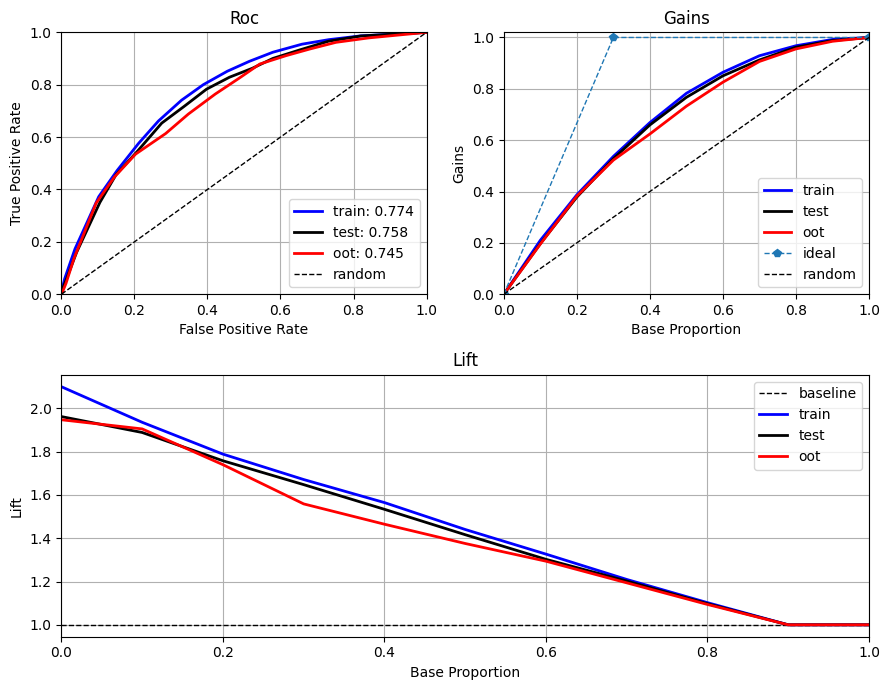

In [225]:
plot_ml_metrics(y_train, train_probas, y_test, test_probas, df_oot[target_col], oot_probas)

### 2.1.2. Logistic Regression Cross Validation

In [132]:
estimator, cv_results = cv_kfold_results(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    X_oot=df_oot.drop(target_col, axis=1),
    y_oot=df_oot[target_col],
    transform_pipeline=pipeline,
    statsmodels=True
)

cv_results

,auc_train,auc_valid,auc_test,auc_oot,k
0,0.775646,0.750572,0.757078,0.744921,1
1,0.773704,0.775909,0.757509,0.745470,2
2,0.776366,0.750704,0.755793,0.744705,3
3,0.771401,0.787339,0.756455,0.744975,4
4,0.775622,0.764478,0.758896,0.745005,5
5,0.775015,0.764136,0.757130,0.744360,6
6,0.772486,0.773035,0.755843,0.744233,7
7,0.770331,0.800371,0.758630,0.746304,8
8,0.774215,0.769275,0.755964,0.744253,9
9,0.776078,0.757983,0.758162,0.745227,10


In [133]:
cv_results.describe().T

,count,mean,std,min,25%,50%,75%,max
auc_train,11.0,0.774075,0.001972,0.770331,0.773095,0.774215,0.775634,0.776366
auc_valid,11.0,0.768301,0.015333,0.750572,0.757747,0.764478,0.774472,0.800371
auc_test,11.0,0.757179,0.001094,0.755793,0.756209,0.757130,0.757836,0.758896
auc_oot,11.0,0.744957,0.000601,0.744233,0.744533,0.744975,0.745151,0.746304
k,11.0,4.909091,3.477198,-1.000000,2.500000,5.000000,7.500000,10.000000


### 2.1.3. Logistic Regression Reduced

My First feature selection is using only p values lower or equal to 0.2 of logistic regression.

Is a total of 15 selected features.

In [440]:
selected_features = [j[0] for j in s.tables[-1].data[1:] if float(j[4].strip()) < .2]
selected_features

['min_order_items_price',
 'avg_order_items_price',
 'max_item_price',
 'min_item_price',
 'quantity_date_orders',
 'quantity_products_selled',
 'quantity_unique_product_selled',
 'avg_seller_interval',
 'ltv',
 'frequency',
 'min_approval_delivery_days',
 'quantity_delay_orders',
 'avg_order_product',
 'min_approval_purchase_days',
 'max_approval_purchase_days']

Logistic regression of statsmodels not consider days from first sell and other features relevant, using only p value, lets check prediction.

Is very cool to see, the freight value is totally irrelevant for predictions, is possible to see in a histograms of EDA the same observation, but, max freight value is a little relevand based only on histograms, lets check the performance.

In [219]:
x_train.columns[~x_train.columns.isin(selected_features)]

Index(['avg_ticket', 'max_order_items_price', 'avg_item_price',
       'avg_freight_value', 'min_freight_value', 'max_freight_value',
       'max_approval_delivery_days', 'days_from_first_sell',
       'avg_approval_purchase_days'],
      dtype='object')

In [220]:
x_train_reduced = x_train[selected_features]
x_test_reduced = x_test[selected_features]
x_oot_reduced = oot[selected_features]

In [221]:
glm = sm.GLM(exog=x_train_reduced, endog=y_train, family=sm.families.Binomial())
glm = glm.fit()

train_probas = glm.predict(exog=x_train_reduced).values
test_probas = glm.predict(exog=x_test_reduced).values
oot_probas = glm.predict(exog=x_oot_reduced).values

glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                 6445
Model:                            GLM   Df Residuals:                     6430
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3378.1
Date:                Sat, 01 Jun 2024   Deviance:                       6756.2
Time:                        20:54:24   Pearson chi2:                 1.17e+04
No. Iterations:                     8   Pseudo R-squ. (CS):             0.1888
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
min_order_items_price             -0.6364      0.358     -1.776      0.076      -1.339       0.066
avg_order_items_price              0.1666      0.050      3.354      0.001       0.069       0.264
max_item_price                    -0.2270      0.047     -4.853      0.000      -0.319      -0.135
min_item_price                     0.5663      0.337      1.680      0.093      -0.094       1.227
quantity_date_orders              -1.0800      0.139     -7.779      0.000      -1.352      -0.808
quantity_products_selled           0.1079      0.067      1.613      0.107      -0.023       0.239
quantity_unique_product_selled    -0.3920      0.089     -4.429      0.000      -0.565      -0.219
avg_seller_interval                0.0839      0.021      3.981      0.000       0.043       0.125
ltv                                0.1075      0.021      5.086      0.000       0.066       0.149
frequency                         -0.1298      0.027     -4.723      0.000      -0.184      -0.076
min_approval_delivery_days         0.0466      0.027      1.727      0.084      -0.006       0.100
quantity_delay_orders              0.1189      0.035      3.383      0.001       0.050       0.188
avg_order_product                 -0.6473      0.521     -1.242      0.214      -1.669       0.374
min_approval_purchase_days         1.6643      0.552      3.016      0.003       0.583       2.746
max_approval_purchase_days        -7.0674      0.559    -12.634      0.000      -8.164      -5.971
==================================================================================================
"""

Metrics do not change.

In [222]:
estimator, cv_results = cv_kfold_results(
    X_train=x_train_reduced,
    y_train=y_train,
    X_test=x_test_reduced,
    y_test=y_test,
    X_oot=x_oot_reduced,
    y_oot=df_oot[target_col],
    transform_pipeline=pipeline,
    statsmodels=True,
    transform_features=False
)

cv_results.describe().T

,count,mean,std,min,25%,50%,75%,max
auc_train,11.0,0.774506,0.002380,0.769858,0.773169,0.774537,0.776460,0.777760
auc_valid,11.0,0.771034,0.020372,0.744169,0.754476,0.774832,0.785016,0.803226
auc_test,11.0,0.758259,0.000635,0.757103,0.757895,0.758341,0.758706,0.759054
auc_oot,11.0,0.744444,0.000608,0.743574,0.744075,0.744455,0.744910,0.745300
k,11.0,4.909091,3.477198,-1.000000,2.500000,5.000000,7.500000,10.000000


OOT Metrics


,p,balanced_accuracy,auc,false_positive_rate,precision,sensibility,specificity,ks_diffs
7,0.35,0.669882,0.744455,0.420321,0.476698,0.760085,0.579679,0.339764
10,0.50,0.669615,0.744455,0.206417,0.571111,0.545648,0.793583,0.339230
8,0.40,0.668548,0.744455,0.350802,0.496933,0.687898,0.649198,0.337096
9,0.45,0.668275,0.744455,0.281283,0.525271,0.617834,0.718717,0.336551
6,0.30,0.666970,0.744455,0.489840,0.458629,0.823779,0.510160,0.333940


Test Metrics


,p,balanced_accuracy,auc,false_positive_rate,precision,sensibility,specificity,ks_diffs
7,0.35,0.696129,0.758329,0.394595,0.474190,0.786853,0.605405,0.392258
8,0.40,0.694081,0.758329,0.336937,0.493225,0.725100,0.663063,0.388163
9,0.45,0.693100,0.758329,0.271171,0.522979,0.657371,0.728829,0.386199
6,0.30,0.688051,0.758329,0.458559,0.451509,0.834661,0.541441,0.376103
5,0.25,0.668662,0.758329,0.525225,0.426181,0.862550,0.474775,0.337325


Train Metrics


,p,balanced_accuracy,auc,false_positive_rate,precision,sensibility,specificity,ks_diffs
8,0.40,0.706800,0.774458,0.330508,0.517391,0.744108,0.669492,0.413599
7,0.35,0.703880,0.774458,0.391663,0.492883,0.799423,0.608337,0.407760
6,0.30,0.698361,0.774458,0.454650,0.471372,0.851371,0.545350,0.396721
9,0.45,0.697454,0.774458,0.269354,0.540086,0.664262,0.730646,0.394908
5,0.25,0.687138,0.774458,0.515575,0.451109,0.889851,0.484425,0.374276


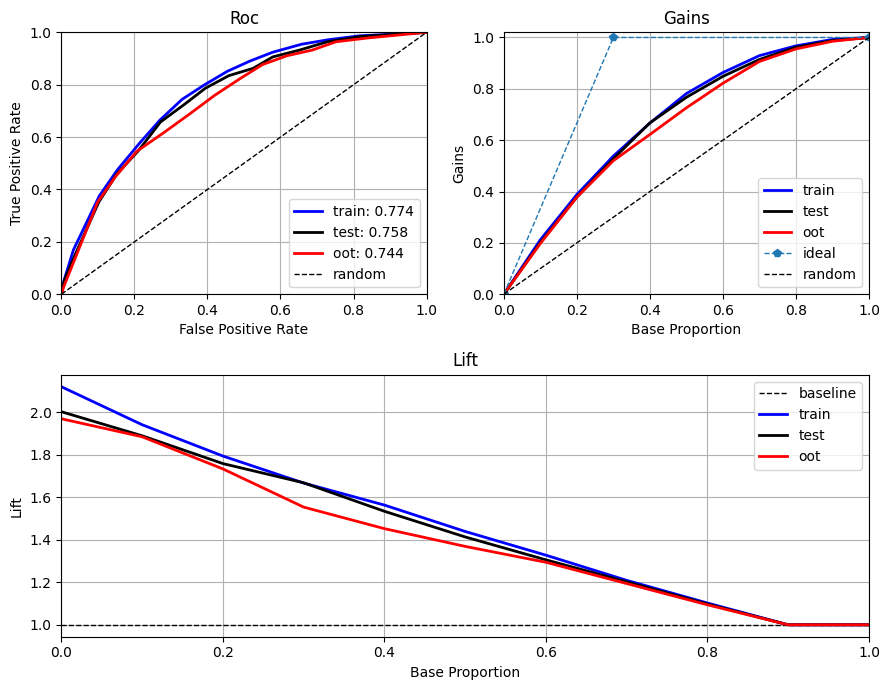

In [223]:
plot_ml_metrics(y_train, train_probas, y_test, test_probas, df_oot[target_col], oot_probas)

### 2.1.4. Logistic Regression Feature Elimination

Is possible to apply feature elimination and check statistics for every feature combination.

In [239]:
combs = []
for r in range(1, len(selected_features) + 1):
    combs.extend(list(combinations(selected_features, r)))
    
combs = [list(comb) for comb in combs]

# All Possible combinarions
combs = [list(l) for r in range(1, len(selected_features) + 1) for l in list(combinations(selected_features, r))]
combs = list(reversed(combs))

# Truncation for 10_000 combinations
combs = combs[:10_000]

In [ ]:
df_eliminations = pd.DataFrame()

for i, comb in enumerate(combs):
    if i % 1000 == 0:
        print(f"{datetime.now()} | Total Fits: {i}")
        
    estimator, cv_results = cv_kfold_results(
        X_train=x_train[comb],
        y_train=y_train,
        X_test=x_test[comb],
        y_test=y_test,
        X_oot=oot[comb],
        y_oot=df_oot[target_col],
        transform_pipeline=pipeline,
        statsmodels=True,
        transform_features=False
    )

    cv_results = cv_results[["auc_train", "auc_oot", "auc_test"]].describe().T[["min", "mean", "max"]].reset_index()
    cv_results["comb_idx"] = i
    df_eliminations = pd.concat([df_eliminations, cv_results], axis=0)

df_eliminations.reset_index(inplace=True)

## 2.2. Sklearn

In [21]:
x_train = pipeline.fit_transform(X_train)
x_train.columns = [j.split("__")[-1] for j in x_train.columns]

x_test = pipeline.transform(X_test)
x_test.columns = [j.split("__")[-1] for j in x_test.columns]

oot = pipeline.transform(df_oot)
oot.columns = [j.split("__")[-1] for j in oot.columns]

### 2.2.1. Logistic Regression

#### 2.2.1.1. Logistic Regression

Logistic Regression for Statsmodels is different from logistic regression of sklearn, is possible to se a minimum difference at coeficients.

Is possible to see a very low coeficients, maybe is a good ideia to feature selection in this coefs.

In [22]:
model = LogisticRegression(
    C=100,
    penalty="l2",
    fit_intercept=True,
    intercept_scaling=1,
    solver="lbfgs",
    class_weight=None,
)

model.fit(x_train, y_train)

train_probas = model.predict_proba(x_train)[:, 1]
test_probas = model.predict_proba(x_test)[:, 1]
oot_probas = model.predict_proba(oot)[:, 1]

In [23]:
estimator_coefs = pd.DataFrame({k: v for k, v in zip(model.feature_names_in_, model.coef_[0])}, index=[0]).T.sort_values(by=0).rename(columns={0: "coef"})
estimator_coefs

,coef
quantity_date_orders,-1.306313
max_approval_purchase_days,-0.831798
quantity_unique_product_selled,-0.492379
min_order_items_price,-0.464819
max_approval_delivery_days,-0.152628
max_freight_value,-0.127125
max_item_price,-0.118727
avg_ticket,-0.069178
avg_item_price,-0.069178
frequency,-0.058565


In [422]:
# Is possible to predeict the proba with very simple steps
1 / (1 + np.exp(-(np.dot(x_test.head(1).values.flatten(), model.coef_.flatten()) + model.intercept_)))

array([0.30164901])

In [307]:
estimator, cv_results = cv_kfold_results(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    X_oot=df_oot.drop(target_col, axis=1),
    y_oot=df_oot[target_col],
    transform_pipeline=pipeline,
    estimator=model
)

cv_results.describe().T

,count,mean,std,min,25%,50%,75%,max
auc_train,11.0,0.788036,0.001685,0.785619,0.787012,0.788080,0.788456,0.790843
auc_valid,11.0,0.784458,0.015712,0.757943,0.778883,0.781828,0.797167,0.804164
auc_test,11.0,0.776789,0.000547,0.776038,0.776490,0.776769,0.776899,0.778204
auc_oot,11.0,0.764563,0.000369,0.764043,0.764313,0.764536,0.764743,0.765146
k,11.0,4.909091,3.477198,-1.000000,2.500000,5.000000,7.500000,10.000000


OOT Metrics


,p,balanced_accuracy,auc,false_positive_rate,precision,sensibility,specificity,ks_diffs
8,0.40,0.698558,0.764769,0.273797,0.552448,0.670913,0.726203,0.397116
7,0.35,0.689732,0.764769,0.363636,0.507246,0.743100,0.636364,0.379463
9,0.45,0.685602,0.764769,0.189305,0.598639,0.560510,0.810695,0.371205
6,0.30,0.682486,0.764769,0.456684,0.475430,0.821656,0.543316,0.364972
5,0.25,0.676373,0.764769,0.530481,0.456140,0.883227,0.469519,0.352746


Test Metrics


,p,balanced_accuracy,auc,false_positive_rate,precision,sensibility,specificity,ks_diffs
7,0.35,0.712365,0.776928,0.334234,0.506649,0.758964,0.665766,0.424730
6,0.30,0.711094,0.776928,0.404505,0.480324,0.826693,0.595495,0.422189
5,0.25,0.694363,0.776928,0.483784,0.449231,0.872510,0.516216,0.388726
8,0.40,0.694166,0.776928,0.263063,0.528271,0.651394,0.736937,0.388331
9,0.45,0.681016,0.776928,0.183784,0.573222,0.545817,0.816216,0.362033


Train Metrics


,p,balanced_accuracy,auc,false_positive_rate,precision,sensibility,specificity,ks_diffs
7,0.35,0.715229,0.787994,0.335776,0.520758,0.766234,0.664224,0.430457
6,0.30,0.713890,0.787994,0.407238,0.494024,0.835017,0.592762,0.427779
8,0.40,0.708940,0.787994,0.252634,0.558270,0.670515,0.747366,0.417881
5,0.25,0.701430,0.787994,0.476409,0.467758,0.879269,0.523591,0.402860
9,0.45,0.691715,0.787994,0.184150,0.594758,0.567581,0.815850,0.383430


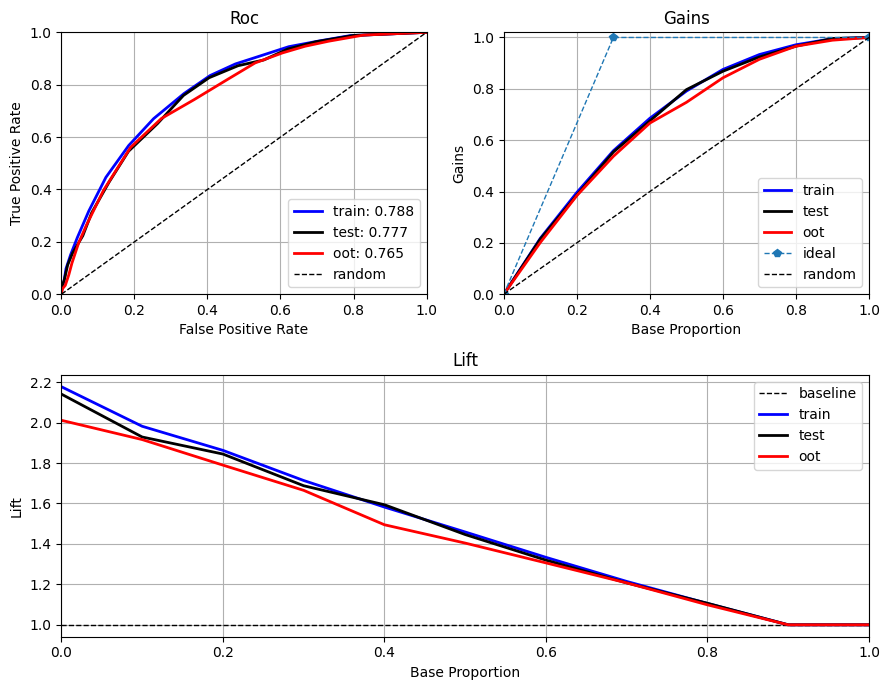

In [423]:
plot_ml_metrics(y_train, train_probas, y_test, test_probas, df_oot[target_col], oot_probas)

#### 2.2.1.2. Lasso Regression

Lasso is used for regression tasks, primarily for feature selection and regularization to prevent overfitting in regression models.

Uses L1 regularization, which tends to produce sparse models by setting some coefficients to exactly zero, effectively performing feature selection, alpha is a constant that multiplies the L1 term, controlling regularization strength.

The optimization objective for Lasso is:

`(1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1`

source: Sklearn.

In [74]:
lasso = Lasso(
    alpha=0.0005,
    tol=1e-4,
    fit_intercept=True
)
lasso.fit(x_train, y_train)

train_probas = lasso.predict(x_train)
test_probas = lasso.predict(x_test)
oot_probas = lasso.predict(oot)

pd.DataFrame({k: v for k, v in zip(lasso.feature_names_in_, lasso.coef_)}, index=[0]).T.sort_values(by=0).rename(columns={0: "coef"})

,coef
quantity_date_orders,-0.119717
max_approval_purchase_days,-0.084866
max_approval_delivery_days,-0.036047
max_freight_value,-0.027075
max_item_price,-0.021533
quantity_unique_product_selled,-0.009587
frequency,-0.001563
max_order_items_price,-0.000000
min_order_items_price,-0.000000
avg_approval_purchase_days,0.000000


OOT Metrics


,p,balanced_accuracy,auc,false_positive_rate,precision,sensibility,specificity,ks_diffs
6,0.30,0.682382,0.757156,0.484492,0.468933,0.849257,0.515508,0.364765
7,0.35,0.677009,0.757156,0.359358,0.500000,0.713376,0.640642,0.354018
8,0.40,0.672289,0.757156,0.201070,0.577528,0.545648,0.798930,0.344578
5,0.25,0.658040,0.757156,0.607487,0.433699,0.923567,0.392513,0.316080
9,0.45,0.638118,0.757156,0.112299,0.635417,0.388535,0.887701,0.276236


Test Metrics


,p,balanced_accuracy,auc,false_positive_rate,precision,sensibility,specificity,ks_diffs
7,0.35,0.705628,0.764908,0.319820,0.508310,0.731076,0.680180,0.411256
6,0.30,0.691370,0.764908,0.445946,0.456641,0.828685,0.554054,0.382739
8,0.40,0.678770,0.764908,0.226126,0.538603,0.583665,0.773874,0.357539
5,0.25,0.674358,0.764908,0.557658,0.423650,0.906375,0.442342,0.348717
9,0.45,0.646696,0.764908,0.146847,0.575521,0.440239,0.853153,0.293392


Train Metrics


,p,balanced_accuracy,auc,false_positive_rate,precision,sensibility,specificity,ks_diffs
7,0.35,0.705231,0.77585,0.330279,0.516432,0.740741,0.669721,0.410461
6,0.30,0.700353,0.77585,0.447778,0.474321,0.848485,0.552222,0.400707
8,0.40,0.687455,0.77585,0.215758,0.565899,0.590669,0.784242,0.374910
5,0.25,0.676293,0.77585,0.562758,0.436468,0.915344,0.437242,0.352586
9,0.45,0.656304,0.77585,0.133761,0.613757,0.446368,0.866239,0.312608


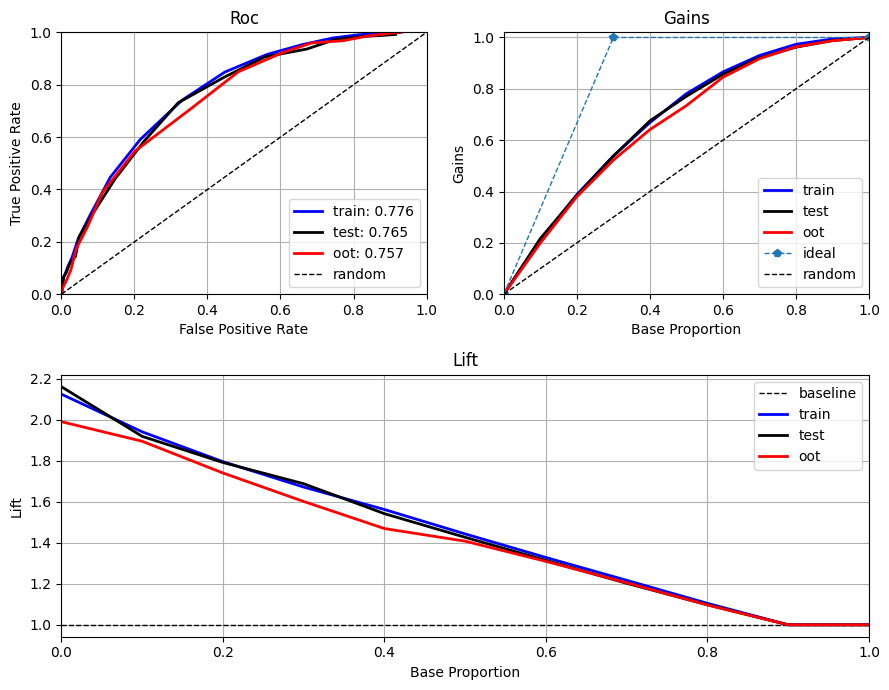

In [75]:
plot_ml_metrics(y_train, train_probas, y_test, test_probas, df_oot[target_col], oot_probas)

### 2.2.2. Logistic Regression Reduced

Linear regression in general, a simple feature can improve the performance, because of that classical feature selection methods will not work very weel without a penalty on DF, AICC or coeficients such as Lasso and Ridge.

For a first try I will select features from P value from statsmodels instead of features selected with Lasso.

In [453]:
selected_features

['min_order_items_price',
 'avg_order_items_price',
 'max_item_price',
 'min_item_price',
 'quantity_date_orders',
 'quantity_products_selled',
 'quantity_unique_product_selled',
 'avg_seller_interval',
 'ltv',
 'frequency',
 'min_approval_delivery_days',
 'quantity_delay_orders',
 'avg_order_product',
 'min_approval_purchase_days',
 'max_approval_purchase_days']

I created a simple RFE for feature selection, is possible to see a minimum feature can improve linear regression estimators in general.

In [448]:
select_rfe_features(x_train, y_train, n_splits=10, select_rank_features=[1])

array(['avg_ticket', 'max_order_items_price', 'min_order_items_price',
       'avg_order_items_price', 'max_item_price', 'min_item_price',
       'avg_item_price', 'quantity_date_orders',
       'quantity_products_selled', 'quantity_unique_product_selled',
       'avg_seller_interval', 'ltv', 'frequency', 'avg_freight_value',
       'max_freight_value', 'min_approval_delivery_days',
       'max_approval_delivery_days', 'quantity_delay_orders',
       'avg_order_product', 'days_from_first_sell',
       'avg_approval_purchase_days', 'min_approval_purchase_days',
       'max_approval_purchase_days'], dtype=object)

With almost half of the features selected, the roc_auc performance metric analyzed in OOT reduced only one point compared to the first training with all features!

With this only 15 features I can create a simulation of changing features values to see the probability of churn, is a good tool for available to Olist marketing team.

In [449]:
x_train_reduced = x_train[selected_features]
x_test_reduced = x_test[selected_features]
x_oot_reduced = oot[selected_features]

estimator, cv_results = cv_kfold_results(
    X_train=x_train_reduced,
    y_train=y_train,
    X_test=x_test_reduced,
    y_test=y_test,
    X_oot=x_oot_reduced,
    y_oot=df_oot[target_col],
    transform_pipeline=pipeline,
    estimator=LogisticRegression(C=100),
    transform_features=False
)

cv_results.describe().T

,count,mean,std,min,25%,50%,75%,max
auc_train,11.0,0.782131,0.001778,0.778559,0.781612,0.782044,0.783230,0.784846
auc_valid,11.0,0.779427,0.015213,0.760198,0.769120,0.779078,0.784443,0.811783
auc_test,11.0,0.768289,0.000560,0.766922,0.768038,0.768361,0.768621,0.768924
auc_oot,11.0,0.757107,0.000651,0.755702,0.756890,0.757210,0.757351,0.758234
k,11.0,4.909091,3.477198,-1.000000,2.500000,5.000000,7.500000,10.000000


OOT Metrics


,p,balanced_accuracy,auc,false_positive_rate,precision,sensibility,specificity,ks_diffs
8,0.40,0.693322,0.75721,0.254545,0.559259,0.641189,0.745455,0.386644
9,0.45,0.680366,0.75721,0.170053,0.611247,0.530786,0.829947,0.360732
6,0.30,0.674009,0.75721,0.452406,0.471250,0.800425,0.547594,0.348018
5,0.25,0.670562,0.75721,0.522995,0.454241,0.864119,0.477005,0.341124
7,0.35,0.669003,0.75721,0.371123,0.490455,0.709130,0.628877,0.338007


Test Metrics


,p,balanced_accuracy,auc,false_positive_rate,precision,sensibility,specificity,ks_diffs
7,0.35,0.708856,0.768325,0.343243,0.500655,0.760956,0.656757,0.417713
6,0.30,0.698812,0.768325,0.417117,0.469037,0.814741,0.582883,0.397624
8,0.40,0.695707,0.768325,0.263964,0.528939,0.655378,0.736036,0.391415
5,0.25,0.681345,0.768325,0.491892,0.440000,0.854582,0.508108,0.362690
9,0.45,0.675586,0.768325,0.184685,0.567511,0.535857,0.815315,0.351172


Train Metrics


,p,balanced_accuracy,auc,false_positive_rate,precision,sensibility,specificity,ks_diffs
7,0.35,0.714610,0.78203,0.339899,0.518651,0.769120,0.660101,0.429221
6,0.30,0.709790,0.78203,0.411590,0.490213,0.831169,0.588410,0.419579
8,0.40,0.704302,0.78203,0.259505,0.550753,0.668110,0.740495,0.408604
5,0.25,0.695796,0.78203,0.481906,0.463265,0.873497,0.518094,0.391591
9,0.45,0.688428,0.78203,0.182547,0.593367,0.559404,0.817453,0.376857


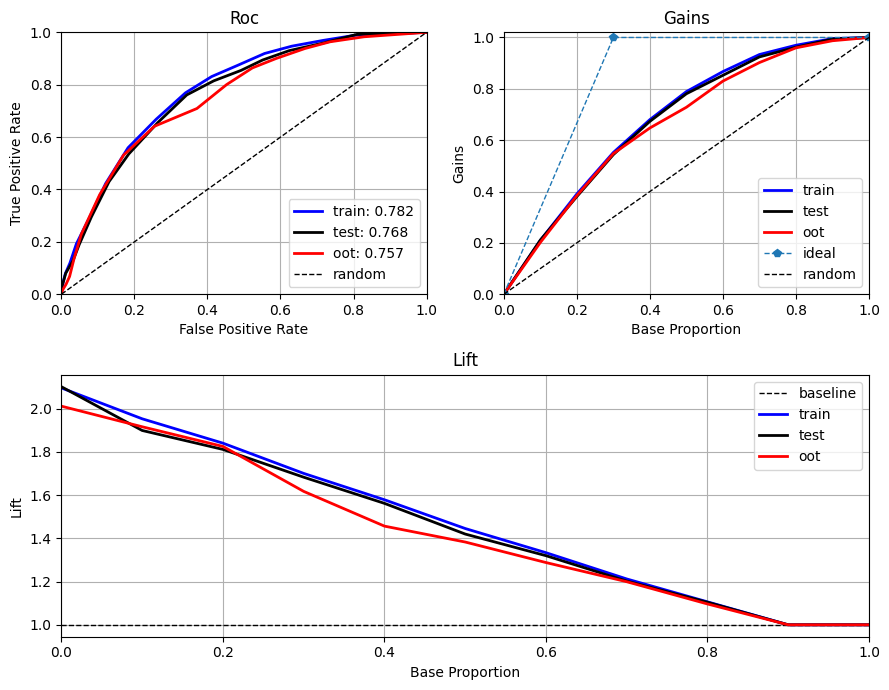

In [452]:
train_probas = estimator.predict_proba(x_train_reduced)[:, 1]
test_probas = estimator.predict_proba(x_test_reduced)[:, 1]
oot_probas = estimator.predict_proba(x_oot_reduced)[:, 1]

plot_ml_metrics(y_train, train_probas, y_test, test_probas, df_oot[target_col], oot_probas)

### 2.2.3. Logistic Regression Grid Search

In [14]:
robust_scaler_features = [
    "min_order_items_price",
    "avg_order_items_price",
    "max_item_price",
    "min_item_price",
    "quantity_date_orders",
    "quantity_products_selled",
    "quantity_unique_product_selled",
    "avg_seller_interval",
    "ltv",
    "frequency",
    "min_approval_delivery_days",
    "quantity_delay_orders"
]

min_max_scaler_features = [
    "avg_order_product",
    "min_approval_purchase_days",
    "max_approval_purchase_days"
]

drop_features = [
    '_mt_date_reference', 'seller_id', 'recency', 'avg_ticket',
    'max_order_items_price', 'avg_item_price', 'days_from_first_sell',
    'avg_freight_value', 'min_freight_value', 'max_freight_value',
    'avg_approval_delivery_days', 'max_approval_delivery_days',
    'avg_approval_purchase_days'
]

In [27]:
drop_features

['_mt_date_reference',
 'seller_id',
 'recency',
 'avg_ticket',
 'max_order_items_price',
 'avg_item_price',
 'days_from_first_sell',
 'avg_freight_value',
 'min_freight_value',
 'max_freight_value',
 'avg_approval_delivery_days',
 'max_approval_delivery_days',
 'avg_approval_purchase_days']

In [41]:
# Param Grid for Grid Search
param_grid = {
    "Estimator__C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "Estimator__solver": ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"],
    "Estimator__penalty": ["l2", None],
    "Estimator__class_weight": ["balanced", None]
}

reduced_pipeline = build_pipeline_estimator(
    robust_scaler_features=robust_scaler_features,
    min_max_scaler_features=min_max_scaler_features,
    drop_features=drop_features,
    estimator=LogisticRegression(C=100)
)

grid = grid_search_cv(
    pipeline=reduced_pipeline,
    X_train=X_train,
    y_train=y_train,
    param_grid=param_grid
)

# Pop Logistic from pipeline
reduced_pipeline.steps.pop()

In [47]:
x_train = reduced_pipeline.fit_transform(X_train)
x_test = reduced_pipeline.transform(X_test)
oot = reduced_pipeline.transform(df_oot)

In [48]:
estimator, cv_results = cv_kfold_results(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    X_oot=df_oot.drop(target_col, axis=1),
    y_oot=df_oot[target_col],
    transform_pipeline=reduced_pipeline,
    estimator=LogisticRegression(**{k.replace("Estimator__", ""):v for k, v in grid.best_params_.items()})
)

cv_results.describe().T

,count,mean,std,min,25%,50%,75%,max
auc_train,11.0,0.781734,0.002250,0.778598,0.779897,0.781783,0.783138,0.785599
auc_valid,11.0,0.779315,0.021554,0.744455,0.766354,0.774468,0.794369,0.812985
auc_test,11.0,0.767020,0.000427,0.766326,0.766762,0.767065,0.767428,0.767510
auc_oot,11.0,0.758389,0.000327,0.757882,0.758193,0.758473,0.758542,0.758959
k,11.0,4.909091,3.477198,-1.000000,2.500000,5.000000,7.500000,10.000000


OOT Metrics


,p,balanced_accuracy,auc,false_positive_rate,precision,sensibility,specificity,ks_diffs
8,0.40,0.693841,0.758502,0.257754,0.557798,0.645435,0.742246,0.387681
9,0.45,0.680901,0.758502,0.168984,0.612745,0.530786,0.831016,0.361802
6,0.30,0.674520,0.758502,0.457754,0.470297,0.806794,0.542246,0.349040
7,0.35,0.673242,0.758502,0.373262,0.492733,0.719745,0.626738,0.346483
5,0.25,0.668934,0.758502,0.532620,0.451542,0.870488,0.467380,0.337868


Test Metrics


,p,balanced_accuracy,auc,false_positive_rate,precision,sensibility,specificity,ks_diffs
7,0.35,0.706249,0.767083,0.350450,0.496114,0.762948,0.649550,0.412498
6,0.30,0.697200,0.767083,0.424324,0.465986,0.818725,0.575676,0.394401
8,0.40,0.695993,0.767083,0.269369,0.526149,0.661355,0.730631,0.391985
5,0.25,0.684618,0.767083,0.497297,0.440729,0.866534,0.502703,0.369237
9,0.45,0.674875,0.767083,0.190090,0.562241,0.539841,0.809910,0.349751


Train Metrics


,p,balanced_accuracy,auc,false_positive_rate,precision,sensibility,specificity,ks_diffs
7,0.35,0.715023,0.781723,0.346770,0.516139,0.776816,0.653230,0.430045
8,0.40,0.707371,0.781723,0.262025,0.551548,0.676768,0.737975,0.414743
6,0.30,0.706663,0.781723,0.421209,0.485450,0.834536,0.578791,0.413326
5,0.25,0.691409,0.781723,0.494045,0.458040,0.876864,0.505955,0.382819
9,0.45,0.686905,0.781723,0.184150,0.590631,0.557961,0.815850,0.373810


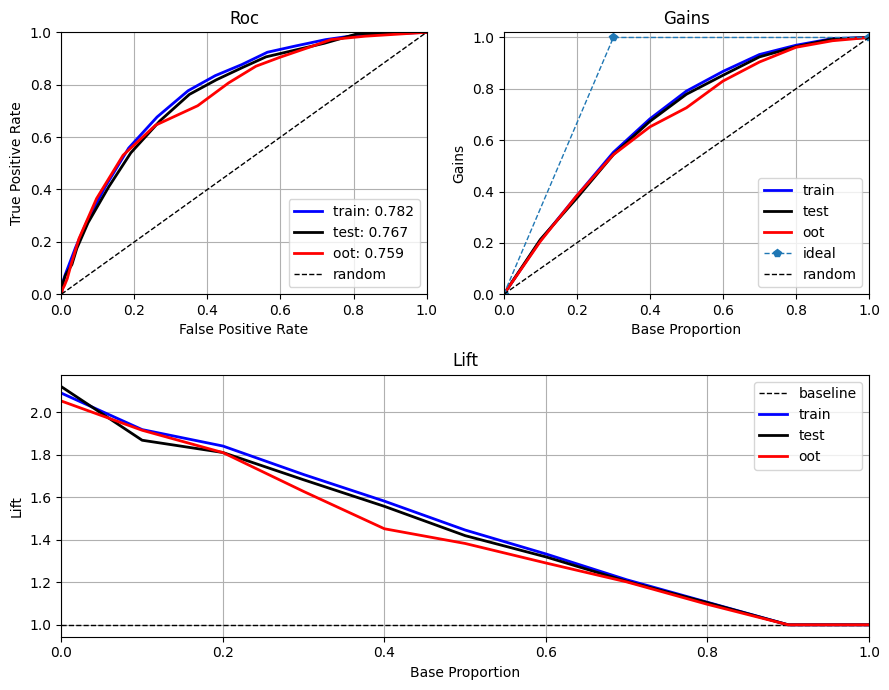

In [49]:
train_probas = estimator.predict_proba(x_train)[:, 1]
test_probas = estimator.predict_proba(x_test)[:, 1]
oot_probas = estimator.predict_proba(oot)[:, 1]

plot_ml_metrics(y_train, train_probas, y_test, test_probas, df_oot[target_col], oot_probas)

In [50]:
get_thresholds_metrics(df_oot[target_col], oot_probas).sort_values(by="ks_diffs").tail(4)

,p,balanced_accuracy,auc,false_positive_rate,precision,sensibility,specificity,ks_diffs
7,0.35,0.673242,0.758502,0.373262,0.492733,0.719745,0.626738,0.346483
6,0.30,0.674520,0.758502,0.457754,0.470297,0.806794,0.542246,0.349040
9,0.45,0.680901,0.758502,0.168984,0.612745,0.530786,0.831016,0.361802
8,0.40,0.693841,0.758502,0.257754,0.557798,0.645435,0.742246,0.387681


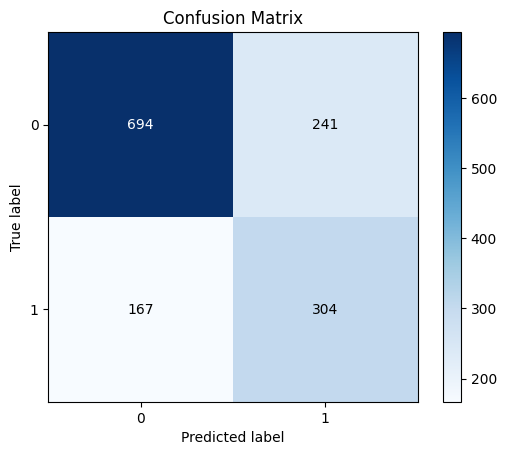

In [51]:
plot_confusion_matrix(df_oot[target_col], [1 if i > 0.4 else 0 for i in oot_probas]);

### 2.2.4. Logistic Regression Final Fit

#### 2.2.4.1. Logistic Regression Oot Test

In [15]:
x = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)

pipeline = build_pipeline_estimator(
    estimator=LogisticRegression(**{'C': 0.1, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}),
    drop_features=drop_features,
    robust_scaler_features=robust_scaler_features,
    min_max_scaler_features=min_max_scaler_features,
)

pipeline.fit(x, y)

oot_probas = pipeline.predict_proba(df_oot)[:, 1]

In [47]:
get_thresholds_metrics(df_oot[target_col], oot_probas).sort_values(by="ks_diffs").tail(4)

,p,balanced_accuracy,auc,false_positive_rate,precision,sensibility,specificity,ks_diffs
5,0.25,0.672653,0.759158,0.531551,0.453846,0.876858,0.468449,0.345307
7,0.35,0.675373,0.759158,0.371123,0.494905,0.721868,0.628877,0.350745
9,0.45,0.679336,0.759158,0.161497,0.618687,0.520170,0.838503,0.358673
8,0.40,0.690656,0.759158,0.257754,0.555351,0.639066,0.742246,0.381312


In [48]:
oot = df_oot[["_mt_date_reference", "seller_id", "churn"]].copy()
oot["proba_churn"] = oot_probas

oot.head()

,_mt_date_reference,seller_id,churn,proba_churn
0,2018-08-01,001cca7ae9ae17fb1caed9dfb1094831,1,0.371361
1,2018-08-01,00720abe85ba0859807595bbf045a33b,0,0.300440
2,2018-08-01,00ee68308b45bc5e2660cd833c3f81cc,0,0.061989
3,2018-08-01,014c0679dd340a0e338872e7ec85666a,1,0.490356
4,2018-08-01,0176f73cc1195f367f7b32db1e5b3aa8,0,0.150535


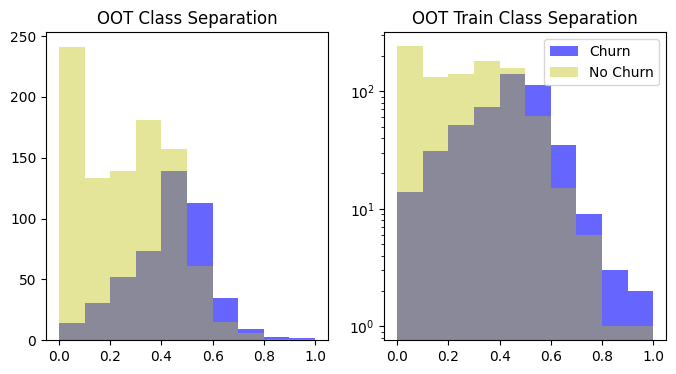

In [31]:
bins = np.arange(0, 1.1, .1)
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax = ax.flatten()

ax[0].hist(oot_probas[df_oot["churn"].astype(bool)],  bins=bins, color="b", label="Churn",    alpha=.6);
ax[0].hist(oot_probas[~df_oot["churn"].astype(bool)], bins=bins, color="y", label="No Churn", alpha=.4);
ax[1].hist(oot_probas[df_oot["churn"].astype(bool)],  bins=bins, color="b", label="Churn",    alpha=.6, log=True);
ax[1].hist(oot_probas[~df_oot["churn"].astype(bool)], bins=bins, color="y", label="No Churn", alpha=.4, log=True);
ax[0].set_title("OOT Class Separation")
ax[1].set_title("OOT Train Class Separation")

plt.legend();

#### 2.2.4.2. Logistic Regression Next Month Inference

For month "2018-09-01" we do not have history, this is the "new fresh clients" to predict proba of churn in production.

In [49]:
df = wr.athena.read_sql_query(
    sql="SELECT * FROM abt_seller_churn",
    database="grc_iceberg_analytics"
)

df = df[df["_mt_date_reference"] == "2018-09-01"]
df.reset_index(drop=True, inplace=True)

Final fit with all available dataset.

In [50]:
x = pd.concat([X_train, X_test, df_oot[X_train.columns]], axis=0)
y = pd.concat([y_train, y_test, df_oot[target_col]], axis=0)

# Complete final pipeline
pipeline = build_pipeline_estimator(
    estimator=LogisticRegression(**{'C': 0.1, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}),
    drop_features=drop_features,
    robust_scaler_features=robust_scaler_features,
    min_max_scaler_features=min_max_scaler_features,
)

pipeline.fit(x, y)

new_sample_probas = pipeline.predict_proba(df)[:, 1]

In [51]:
df_new_sample = df[["_mt_date_reference", "seller_id"]].copy()
df_new_sample["churn_proba"] = [np.round(j, 3) for j in new_sample_probas]

Top 100 churn sellers sorted by logistic regression probas.

In [52]:
df_new_sample.sort_values(by="churn_proba", ascending=False).head(100)

,_mt_date_reference,seller_id,churn_proba
784,2018-09-01,80ceebb4ee9b31afb6c6a916a574a1e2,0.962
11,2018-09-01,02d35243ea2e497335cd0f076b45675d,0.875
492,2018-09-01,53243585a1d6dc2643021fd1853d8905,0.872
1120,2018-09-01,c004e5ea15737026cecaee0447e00b75,0.867
1476,2018-09-01,fcf16b7a8697e559f0123190bb30177d,0.854
...,...,...,...
963,2018-09-01,a1544b9ea0b2390e020537d4daa89049,0.588
183,2018-09-01,1e9d5a33694bddb76316fd1f54734d20,0.587
959,2018-09-01,a0d7fbb07bb5ebc3b05980e750db56f3,0.586
887,2018-09-01,94231344608e603693b0a8891143f65d,0.586


In [55]:
joblib.dump(pipeline, "logistic_regression_final.joblib")

['logistic_regression_final.joblib']

# 3.0. Business Performance

If the Olist seller goes into churn, I'm losing a lot of money depending on the projected LTV for that seller. Assuming that there is no LTV forecast, I will make a very simple trend holt forecast taking into account a linear trend just to have a basis for calculating the estimator ROI.

Why?

The marketing team of Olist have a monetary incentive to prevent seller for churning, but the finance team have a budget of $ 5.000 to spend with this monetary gift cards incentive.

The objective is to maximize ROI with marketing investiment of gits cards and work with finance budget.

I do not have historical data of marketing incentive gifts to check the efficiency of the gifts, but I can create some scenarios.

- If churn proba > 95%, this seller will leave of Olist, maybe a very big incentive is possible to use, but i will skip this sellers.
- If churn proba is between 95% to 85% a gift card of $200 can be a solution for retain this seller.
- If churn proba is between 85% to 75% a gift card of $100 can retain.
- Others sellers with probability of churn lower than 75% a gift card of $50 can be a solution.

In [166]:
df = wr.athena.read_sql_query(
    sql="SELECT * FROM abt_seller_churn",
    database="grc_iceberg_analytics"
)

df = df[df["_mt_date_reference"] == "2018-09-01"]
df.reset_index(drop=True, inplace=True)

pipe = joblib.load("logistic_regression_final.joblib")
probas = pipe.predict_proba(df)[:, 1]

df = df[["_mt_date_reference", "seller_id"]]
df["churn_proba"] = np.round(probas, 3)

df.head(5)

,_mt_date_reference,seller_id,churn_proba
0,2018-09-01,00720abe85ba0859807595bbf045a33b,0.305
1,2018-09-01,00ee68308b45bc5e2660cd833c3f81cc,0.107
2,2018-09-01,01266d4c46afa519678d16a8b683d325,0.412
3,2018-09-01,014d9a685fd57276679edd00e07089e5,0.372
4,2018-09-01,0176f73cc1195f367f7b32db1e5b3aa8,0.161


## 3.1. LTV Forecasting

In [33]:
df_ltv_history = read_query("intermitent_time_series.sql")

# Filter available sellers at OOT
df_ltv_history = pd.merge(df_ltv_history, df, on="seller_id", how="inner")

# Rename columns
df_ltv_history = df_ltv_history[["seller_id", "order_month_purchase", "forecast_ltv"]]
df_ltv_history.columns = ["unique_id", "ds", "y"]

In [34]:
# Forecast next month LTV
sf = StatsForecast(models=[Holt(season_length=12)], freq="M")
sf.fit(df_ltv_history)

forecasting = sf.forecast(h=1).reset_index()
forecasting.columns = ["unique_id", "ds", "y"]
forecasting["y"] = forecasting["y"].apply(lambda x: 0 if x < 0 else x)
forecasting["ds"] = "2018-09-01"

df_ltv_history = pd.concat([df_ltv_history, forecasting])
df_ltv_history = df_ltv_history.sort_values(by=["unique_id", "ds"], ascending=True).reset_index(drop=True)

In [35]:
df_ltv_history.tail()

,unique_id,ds,y
22420,fffd5413c0700ac820c7069d66d98c89,2018-05-01,8006.000000
22421,fffd5413c0700ac820c7069d66d98c89,2018-06-01,8254.300000
22422,fffd5413c0700ac820c7069d66d98c89,2018-07-01,8540.300000
22423,fffd5413c0700ac820c7069d66d98c89,2018-08-01,9025.700000
22424,fffd5413c0700ac820c7069d66d98c89,2018-09-01,9694.547852


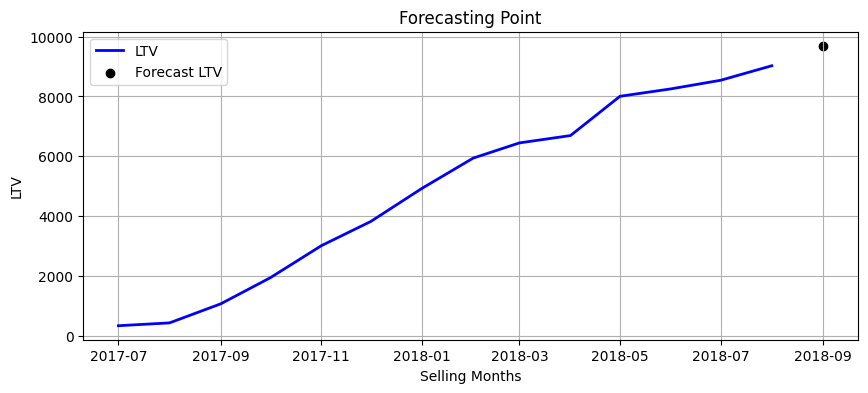

In [94]:
plot_forecast_ltv_sample(df_ltv_history)

One approach is also to analyze only the monthly earnings, that is, how much the seller earned this month instead of complete LTV.

A seller who had an LTV of 200 in four months is different than a seller who had an LTV of 200 in just one month.

In [36]:
df_ltv_history["sltv"] = df_ltv_history[["unique_id", "y"]].groupby("unique_id").shift(1)["y"]

df_ltv_history["current_month_profit"] = df_ltv_history["y"] - df_ltv_history["sltv"]

This seller below have a LTV of "269174.15625", but in the last month this seller get "17884.67625".

In [37]:
df_ltv_history.loc[df_ltv_history.unique_id == "7c67e1448b00f6e969d365cea6b010ab", ["ds", "y", "current_month_profit"]]

,ds,y,current_month_profit
11340,2017-07-01,18761.41000,NaN
11341,2017-08-01,29647.81000,10886.40000
11342,2017-09-01,41055.49000,11407.68000
11343,2017-10-01,72420.21000,31364.72000
11344,2017-11-01,94583.54000,22163.33000
11345,2017-12-01,100639.39000,6055.85000
11346,2018-01-01,123411.72000,22772.33000
11347,2018-02-01,148765.72000,25354.00000
11348,2018-03-01,186460.34000,37694.62000
11349,2018-04-01,212385.48000,25925.14000


## 3.2. Sellers ROI

I have an estimator in my hands that describes the probability of a seller churning.

Now I have the LTV of each seller and their probas of churn.

The marketing of Olist will created a gift cards strategy to retain this sellers to not churn, but the financial team have a limit budget to invest in this project, a limit of $ 5.000, I need to maximize investiment of gift cards in certain sellers.

One very simple approach is to sort sellers by probas and give a monetary incentives exponentially decreassing over the probas.

A second approach is to use LTV as weight for better selecting clients, this fits into knapsack problem.

In [167]:
forecasting.sort_values(by=["ds", "unique_id"], inplace=True)
df.sort_values(by=["_mt_date_reference", "seller_id"], inplace=True)

# Create LTV
df["ltv"] = forecasting["y"]
df = df[["seller_id", "churn_proba", "ltv"]]

# Create Gifts
df["gift"] = df["churn_proba"].apply(lambda x: 10000 if x >= .95 else
                                                 400 if x < .95 and x >= .85 else 
                                                 100 if x < .85 and x >= .75 else 50)

# Filter Churn probas clients greather than 0.5
df_churn_seller = df[df["churn_proba"] >= 0.5].reset_index(drop=True).copy()

In [92]:
df.tail()

,seller_id,churn_proba,ltv,gift
1490,ff1fb4c404b2efe68b03350a8dc24122,0.064,7800.992188,50
1491,ffa6adafb71b807dc13159e26431354c,0.221,1651.969116,50
1492,ffc470761de7d0232558ba5e786e57b7,0.162,1864.795166,50
1493,ffdd9f82b9a447f6f8d4b91554cc7dd3,0.404,1860.620728,50
1494,fffd5413c0700ac820c7069d66d98c89,0.156,9694.547852,50


### 3.2.1. Sellers Churn Scored Gifts

I will work with sellers that have probability of churn greather than 50% and lower than 99% (marketing incentive constraints for 99% of probability of churn).

In [106]:
df_churn_seller_scored = df_churn_seller[df_churn_seller["gift"] < 10000].sort_values(by="churn_proba", ascending=False).reset_index(drop=True)
df_churn_seller_scored = df_churn_seller_scored[df_churn_seller_scored["gift"].cumsum() <= 5000]

### 3.2.2. Sellers Churn Selected Gifts

I will work with sellers that have greather than 50% of churn to find best sellers to give gift using LTV, Gifts and Finance budget.

With this solution I can find a best combination of maximizing LTV of sellers that have a probability of churn using finance available budget, assuming marketing incentives will work for all sellers because do not exists historical data of this marketing incentives before.

In [168]:
# Generate Knapsack to churn sellers p(>0.5)
profit = df_churn_seller["ltv"].values.tolist()
weight = df_churn_seller["gift"].values.tolist()
W = 5000

churn_seller_ltv, churn_seller_keeps = tqdm(knapsack(W, weight, profit))
df_churn_seller["keep"] = churn_seller_keeps
df_keep_churn_seller = df_churn_seller[df_churn_seller["keep"]].reset_index(drop=True)

100%|██████████| 2/2 [00:00<00:00, 51150.05it/s]


### 3.2.3. Business Results

In [234]:
estimated_ltv_profit_without_churn = np.round(df['ltv'].sum(), 3)
last_month_profit = df_ltv_history[df_ltv_history["ds"] == "2018-08-01"]["y"].sum()

scored_total_retain_sellers = df_churn_seller_scored["seller_id"].nunique()
scored_total_spended_gifts = df_churn_seller_scored["gift"].sum()
scored_total_retain_ltv = df_churn_seller_scored["ltv"].sum()

k_total_retain_sellers = df_keep_churn_seller["seller_id"].nunique()
k_total_spended_gifts = df_keep_churn_seller["gift"].sum()
k_total_retain_ltv = df_keep_churn_seller["ltv"].sum()

all_50_sellers = df_churn_seller["seller_id"].nunique()
all_50_total_ltv = df_churn_seller["ltv"].sum()
all_50_total_gift_to_spend = df_churn_seller["gift"].sum()

all_50_total_ltv = "${:,.2f}".format(all_50_total_ltv)
all_50_total_gift_to_spend = "${:,.2f}".format(all_50_total_gift_to_spend)

estimated_ltv_profit_without_churn = "${:,.2f}".format(estimated_ltv_profit_without_churn)
last_month_profit = "${:,.2f}".format(last_month_profit)
scored_total_retain_ltv = "${:,.2f}".format(scored_total_retain_ltv)
k_total_retain_ltv = "${:,.2f}".format(k_total_retain_ltv)

In [237]:
print("-- Geral Overview --")
print(f"Last Month Profit: {last_month_profit}.")
print(f"Estimated Profit for this month: {estimated_ltv_profit_without_churn}.")

-- Geral Overview --
Last Month Profit: $9,610,970.22.
Estimated Profit for this month: $10,225,204.19.


In [207]:
print("-- Sellers with 50% Probability of Churn Overview --")
print(f"Quantity of {all_50_sellers} sellers.")
print(f"Total of LTV: {all_50_total_ltv}")
print(f"Total Gift to Spend to Retain all: {all_50_total_gift_to_spend}\n")

print(f"Scored Only Business Metrics")
print(f"Total Retained LTV: {scored_total_retain_ltv}")
print(f"Total Spended in Gifts: {scored_total_spended_gifts}")
print(f"Total Retained Sellers: {scored_total_retain_sellers} ({(scored_total_retain_sellers / all_50_sellers * 100):.2f}% of Sellers)\n")

print(f"Optimal Solution Business Metrics")
print(f"Total Retained LTV: {k_total_retain_ltv}")
print(f"Total Spended in Gifts: {k_total_spended_gifts}")
print(f"Total Retained Sellers: {k_total_retain_sellers} ({(k_total_retain_sellers / all_50_sellers * 100):.2f}% of Sellers)")

-- Sellers with 50% Probability of Churn Overview --
Quantity of 268 sellers.
Total of LTV: $487,035.81
Total Gift to Spend to Retain all: $25,550.00

Scored Only Business Metrics
Total Retained LTV: $295,666.82
Total Spended in Gifts: 5000
Total Retained Sellers: 56 (20.90% of Sellers)

Optimal Solution Business Metrics
Total Retained LTV: $462,048.67
Total Spended in Gifts: 5000
Total Retained Sellers: 90 (33.58% of Sellers)


# 4.0. Production Inference

Churn probas for all ABT records.

In [99]:
df = wr.athena.read_sql_query(
    sql="SELECT * FROM abt_seller_churn",
    database="grc_iceberg_analytics"
)

pipeline = joblib.load("logistic_regression_final.joblib")
churn_probas = pipeline.predict_proba(df)[:, 1]

df = df[["_mt_date_reference", "seller_id"]]
df["churn_proba"] = np.round(churn_probas, 3)

df[["_mt_date_reference", "churn_proba"]].groupby("_mt_date_reference").mean()

,churn_proba
_mt_date_reference,
2018-01-01,0.341462
2018-02-01,0.324218
2018-03-01,0.328181
2018-04-01,0.319302
2018-05-01,0.320072
2018-06-01,0.320271
2018-07-01,0.314166
2018-08-01,0.322030
2018-09-01,0.327892
